# Reasonable way to place macros in text.

Some strings contain delimiters that identify them with a specific syntax.

* Markdown has ticks
* Yaml has dashes
* Graphviz has graph/digraph
* Latex has Dollar signs.

## Usage

Install [__deathbeds__](https://github.com/deathbeds/deathbeds.github.io)

        with __import__('importnb').Notebook():
            %reload_ext deathbeds.__String_Node__

# The Node Transformer

The node transformer is an structured way to modify code.  [__greentreesnakes__](https://greentreesnakes.readthedocs.io/) is a great document for understanding the Python ast.

In [1]:
    import ast, abc, doctest, types, unittest
    import os
    os.environ['PATH'] = ';'.join([os.environ['PATH'], "C:/Program Files (x86)/Graphviz2.38/bin"])

The NodeTransformer will takes two attributes:

* A condition that must be satisfied to trigger the replacement.
* A formatable string that can be replaced with the desired source.

This class is to be reused as a base class.

    >>> class NewTransformer(StrTokenTransformerMeta): ...

In [2]:
    class StrTokenTransformerMeta(ast.NodeTransformer, metaclass=abc.ABCMeta):
        @abc.abstractstaticmethod
        def condition(self, callable: str) -> bool:
            """A callable that tests a string condition."""
            raise NotImplemented()
            
        @abc.abstractproperty
        def replacement(self, str) -> str:
            """A block string to replace a condition with."""
            raise NotImplemented()
            
        

> `abstractproperty` is not required, but it doesn't hurt.  If this is confusing, just know we can't create a new `StrTokenTransformerMeta` class without the `condition` or `replacement` attributes existing and being `staticmethod` and `abstractproperty`, respectively.

`StrTokenTransformer` defines import `NodeTransformer` attributes.

In [14]:
    class StrTokenTransformer(StrTokenTransformerMeta):
        def generic_visit(self, node): return node
        
        def visit_Expr(self, node):
            if isinstance(node.value, ast.Str):
                str = node.value.s
                if self.condition(str):
                    return ast.parse(self.replace(str)).body[0]
            return node
        
        visit_Try = visit_If = visit_Module = ast.NodeTransformer.generic_visit
        
        def replace(self, str):
            """Validate the source, before continuing."""
            self.validate()
            quotes = '"""'
            if quotes in str: quotes = "'''"
            return self.replacement.format(
                quotes + '{}' + quotes).format(str)
            
        def validate(self):
            """Validate that the replacement string is Python."""
            try: ast.parse(self.replacement)
            except: raise StrTokenTransformerException(self.replacement)
                

It is a good practice to define our own exceptions.

In [4]:
    class StrTokenTransformerException(BaseException): ...

## A graphviz replacement

When a string starts with __graph__ or __digraph__ show a [__graphviz__]() repr.

In [5]:
    if False: import graphviz
    class GraphViz(StrTokenTransformer):
        replacement = """__import__('IPython').display.display(__import__('graphviz').Source({}))"""
        condition = staticmethod(lambda str: str.startswith('graph') or str.startswith('digraph'))

> The graphviz syntax looks extra boss with [Fira-Code]().

## A yaml replacement

In [6]:
    class YamlDefinition(StrTokenTransformer):
        replacement = """globals().update(
            __import__('collections').ChainMap(*reversed(list(
                __import__('yaml').safe_load_all(
                    __import__('io').StringIO({}))))))"""
        condition = staticmethod(lambda str: str.startswith('---\n'))

## An Iframe replacement.

In [7]:
    class IframeDisplay(StrTokenTransformer):
        replacement = """__import__('IPython').display.display(
            __import__('IPython').display.IFrame(
                {}, 600, 400))"""
        condition = staticmethod(lambda str: str.startswith('http:') or str.startswith('https:'))

## A tester

In [8]:
    class DoctestString(StrTokenTransformer):
        replacement = """__import__('doctest').testmod(
            __import__('types').ModuleType('test', {}), globs=vars(__import__(__name__)))"""
        condition = staticmethod(lambda str: any(line.lstrip().startswith('>>> ') for line in str.splitlines()))

## An IPython extension

In [9]:
    def load_ipython_extension(ip=None):
        ip = ip or __import__('IPython').get_ipython()
        ip.ast_transformers = [GraphViz(), YamlDefinition(), IframeDisplay(), DoctestString()]
        
    load = load_ipython_extension

## Usage

    >> __import__('__String_Node_Transformer').load()

In [10]:
    Ø = __name__ == '__main__'
    if Ø: load_ipython_extension()

### GraphViz Example

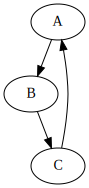

In [11]:
    if Ø: """digraph {A->B->C->A}"""

### Yaml Example

In [12]:
    if Ø:
        """---
    foo: 42
    ---
    foo: 100"""
        if Ø: assert foo is 100, """The transformer is likely not loaded."""

### Doctesting

In [13]:
    if Ø: """>>> 1
    1"""

# What other replacements could you imagine?

* This should work with Formatted strings or JoinedStr.